In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import unidecode
import nltk 
from tqdm import tqdm

from wordcloud.wordcloud import STOPWORDS, WordCloud
from spacy.lang.pt.stop_words import STOP_WORDS

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
#!pip install spacy
#!pip install wordcloud
#!pip install nltk

In [3]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download pt_core_news_sm

In [4]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [5]:
viagem_df = pd.read_csv("2022_Viagem.csv", sep=";", encoding="latin-1")
viagem_df.head(10)

,Identificador do processo de viagem,Número da Proposta (PCDP),Situação,Viagem Urgente,Justificativa Urgência Viagem,Código do órgão superior,Nome do órgão superior,Código órgão solicitante,Nome órgão solicitante,CPF viajante,...,Função,Descrição Função,Período - Data de início,Período - Data de fim,Destinos,Motivo,Valor diárias,Valor passagens,Valor devolução,Valor outros gastos
0,17438343,000001/22,Realizada,NÃO,Sem informação,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.188.261-**,...,-1,Não Informado,12/02/2022,14/02/2022,Brasília/DF,Servidor designado em missão transitória na Em...,"0,00","0,00","0,00","0,00"
1,17503013,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID012100276,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,24/04/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"20995,16","0,00","0,00","0,00"
2,17503072,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID006700175,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,04/11/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"63045,68","0,00","0,00","0,00"
3,17503094,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID005400135,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,08/09/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"49353,83","0,00","0,00","0,00"
4,17513261,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID214200100,...,Sigilosa,Informações protegidas por sigilo,01/01/2022,29/08/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,"36225,93","0,00","0,00","0,00"
5,17513655,000001/22,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26352,Fundação Universidade Federal do ABC,***.509.067-**,...,-1,Não Informado,04/01/2022,16/12/2022,Londres/Reino Unido,Realização de pós-doutorado na London School o...,"0,00","0,00","0,00","0,00"
6,17538368,005154/22,Realizada,SIM,Devido a urgência da demanda.,49000,Ministério do Desenvolvimento Agrário,22201,Instituto Nacional de Colonização e Reforma Ag...,***.580.462-**,...,-1,Não Informado,08/08/2022,13/08/2022,Belterra/PA,Realizar atividades relacionadas à implementaç...,"1550,85","0,00","0,00","0,00"
7,17563956,000002/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.450.349-**,...,-1,Não Informado,07/02/2022,12/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,"964,40","6919,20","0,00","0,00"
8,17564009,000001/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.011.204-**,...,-1,Não Informado,07/02/2022,11/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,"891,50","7561,20","0,00","0,00"
9,17569036,000002/22-3C,Realizada,SIM,Não há.,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.272.667-**,...,FGR-1,FGR-1,06/03/2022,07/03/2022,Brasília/DF,Servidor designado em missão transitória na Em...,"0,00","2801,39","0,00","0,00"


In [6]:
viagem_df.columns = ["id_viagem", "numero_proposta", "situacao", "viagem_urgente", "justificativa_urgencia_viagem",
                     "codigo_orgao_superior", "nome_orgao_superior", "codigo_orgao_solicitante", "nome_orgao_solicitante",
                     "cpf_viajante", "nome", "cargo", "funcao", "descricao_funcao",
                     "data_inicio", "data_fim", "destinos", "motivo", "valor_diarias",
                     "valor_passagens", "valor_devolucao", "valor_outros_gastos"]

# convert valores to float
viagem_df["valor_diarias"] = viagem_df["valor_diarias"].str.replace(",", ".").astype(float)
viagem_df["valor_passagens"] = viagem_df["valor_passagens"].str.replace(",", ".").astype(float)
viagem_df["valor_devolucao"] = viagem_df["valor_devolucao"].str.replace(",", ".").astype(float)
viagem_df["valor_outros_gastos"] = viagem_df["valor_outros_gastos"].str.replace(",", ".").astype(float)


In [7]:
viagem_df[viagem_df["viagem_urgente"] == "SIM"]["justificativa_urgencia_viagem"]

6                             Devido a urgência da demanda.
7         realização de coletas das amostras biológicas ...
8         realização de coletas das amostras biológicas ...
9                                                   Não há.
42                                       Conforme portaria.
                                ...                        
647668                      VIAGEM CONFIRMADA FORA DO PRAZO
647669                    CONFORME O.S. 4998/2022 EM ANEXO.
647670                    CONFORME O.S. 5104/2022 EM ANEXO.
647671                    DE ACORDO COM A ORDEM DE SERVIÇO.
647672                    DE ACORDO COM A ORDEM DE SERVIÇO.
Name: justificativa_urgencia_viagem, Length: 387011, dtype: object

In [8]:
viagem_df['justificativa_urgencia_viagem_SIM'] = viagem_df[viagem_df["viagem_urgente"] == "SIM"]["justificativa_urgencia_viagem"]
viagem_df.head(10)

,id_viagem,numero_proposta,situacao,viagem_urgente,justificativa_urgencia_viagem,codigo_orgao_superior,nome_orgao_superior,codigo_orgao_solicitante,nome_orgao_solicitante,cpf_viajante,...,descricao_funcao,data_inicio,data_fim,destinos,motivo,valor_diarias,valor_passagens,valor_devolucao,valor_outros_gastos,justificativa_urgencia_viagem_SIM
0,17438343,000001/22,Realizada,NÃO,Sem informação,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.188.261-**,...,Não Informado,12/02/2022,14/02/2022,Brasília/DF,Servidor designado em missão transitória na Em...,0.00,0.00,0.0,0.0,NaN
1,17503013,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID012100276,...,Informações protegidas por sigilo,01/01/2022,24/04/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,20995.16,0.00,0.0,0.0,NaN
2,17503072,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID006700175,...,Informações protegidas por sigilo,01/01/2022,04/11/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,63045.68,0.00,0.0,0.0,NaN
3,17503094,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID005400135,...,Informações protegidas por sigilo,01/01/2022,08/09/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,49353.83,0.00,0.0,0.0,NaN
4,17513261,Informações pro,Realizada,NÃO,Informação protegida por sigilo nos termos da ...,30000,Ministério da Justiça e Segurança Pública,30108,Departamento de Polícia Federal,ID214200100,...,Informações protegidas por sigilo,01/01/2022,29/08/2022,Informações protegidas por sigilo,Informação protegida por sigilo nos termos da ...,36225.93,0.00,0.0,0.0,NaN
5,17513655,000001/22,Realizada,NÃO,Sem informação,26000,Ministério da Educação,26352,Fundação Universidade Federal do ABC,***.509.067-**,...,Não Informado,04/01/2022,16/12/2022,Londres/Reino Unido,Realização de pós-doutorado na London School o...,0.00,0.00,0.0,0.0,NaN
6,17538368,005154/22,Realizada,SIM,Devido a urgência da demanda.,49000,Ministério do Desenvolvimento Agrário,22201,Instituto Nacional de Colonização e Reforma Ag...,***.580.462-**,...,Não Informado,08/08/2022,13/08/2022,Belterra/PA,Realizar atividades relacionadas à implementaç...,1550.85,0.00,0.0,0.0,Devido a urgência da demanda.
7,17563956,000002/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.450.349-**,...,Não Informado,07/02/2022,12/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,964.40,6919.20,0.0,0.0,realização de coletas das amostras biológicas ...
8,17564009,000001/22-2C,Realizada,SIM,realização de coletas das amostras biológicas ...,44000,Ministério do Meio Ambiente,44207,Instituto Chico Mendes de Conservação da Biodi...,***.011.204-**,...,Não Informado,07/02/2022,11/02/2022,Fernando de Noronha/PE,Participar da realização de coletas das amostr...,891.50,7561.20,0.0,0.0,realização de coletas das amostras biológicas ...
9,17569036,000002/22-3C,Realizada,SIM,Não há.,35000,Ministério das Relações Exteriores,35000,Ministério das Relações Exteriores - Unidades ...,***.272.667-**,...,FGR-1,06/03/2022,07/03/2022,Brasília/DF,Servidor designado em missão transitória na Em...,0.00,2801.39,0.0,0.0,Não há.


# Pré-Processamento de Texto

In [9]:
wl = WordNetLemmatizer()

def obter_stopwords():
    stopwords = []
        
    stopwords.extend([unidecode.unidecode(palavra.lower().replace(" ", "")) for palavra in nltk.corpus.stopwords.words('portuguese')])
    stopwords.extend([unidecode.unidecode(palavra.lower().replace(" ", "")) for palavra in STOPWORDS])
    stopwords.extend([unidecode.unidecode(word.lower().replace(" ", "")) for word in STOP_WORDS])
    
    stopwords_viagens = ['viagem','viajar', 'viagens', 'turismo','turista','destino',
                         'passeio','ferias','aventura','explorar','explorador',
                         'visitar','viajante','itinerário','roteiro','hospedagem',
                         'hotel','hostel','albergue','voo','aeroporto',
                         'aviao','bagagem','mala','mochila','passaporte',
                         'visto','fronteira','imigração','embarque','desembarque',
                         'guia','mapa','atracao','monumento','cultura',
                         'experiencia','seguro','agencia','cambio','moeda',
                         'transporte','carro','onibus','trem','navio',
                         'cruzeiro','praia','montanha','cidade','pais',
                         'conforme', 'devido', 'devida', 'dia', 'dias', 'diaria', 'diarias'
                         'junto', 'sendo', 'sido',
                        ]
    
    stopwords.extend(stopwords_viagens)
        
    stopwords = list(set(stopwords))
    stopwords.sort()
    
    return stopwords

# remove todos stopwords no texto
def remocao_stopwords(string):
    
    stopwords = obter_stopwords()
    texto_limpo = [i for i in string.split() if i not in stopwords]
    
    return ' '.join(texto_limpo)

# remove textos desnecessários como pontuação, números, caracteres especiais e URLs no texto
def limpeza_texto(text):
    text = unidecode.unidecode(str(text).lower().strip()) 
    text= re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=  re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub("@\S+", "", text)
    text = re.sub("\$", "", text)
    text = re.sub("https?:\/\/.*[\r\n]*", "", text)
    text = re.sub("#", "", text)
    text = re.sub(r'https?:\/\/[\r\n],"[\r\n]"', '', text, flags=re.MULTILINE) 
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]',' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub('[^a-zà-ù ]', ' ', text)
    return text

 
# classificar token em categoria gramatica 
def obter_pos_tag(token):
    if token.startswith('J'):
        return wordnet.ADJ # Adjetivos
    elif token.startswith('V'):
        return wordnet.VERB # Verbos
    elif token.startswith('N'):
        return wordnet.NOUN # Substantivos
    elif token.startswith('R'):
        return wordnet.ADV # Advérbios
    else:
        return wordnet.NOUN # Substantivos
    
# coverte palavras em sua forma canônica, conhecida como "lema"
def lematizacao(string):
    token =word_tokenize(string)
    word_pos_tags = nltk.pos_tag(token) # classificação da classe gramatica do token ("agora" ,"RV")
    texto_limpo =[wl.lemmatize(tag[0], obter_pos_tag(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(texto_limpo)

# Função para realizar a stemização em uma palavra
def stemmer(word):
    # Inicializar o stemmer
    stemmer = SnowballStemmer('portuguese')
    return stemmer.stem(word)

In [10]:
# procedimento demorado depedendo do tamanho da base de dados
# então feito somente uma unica vez no projeto 
def pre_processamento_texto(texto):
    texto = limpeza_texto(texto)
    texto = remocao_stopwords(texto)
    texto = lematizacao(texto)
    return texto

In [11]:
tqdm.pandas()
viagem_df['justificativa_urgencia_viagem_SIM_limpo'] = viagem_df['justificativa_urgencia_viagem_SIM'].progress_apply(lambda x: pre_processamento_texto(str(x)))

100%|█████████████████████████████████████████████████████████████████████████| 648252/648252 [36:46<00:00, 293.85it/s]


In [12]:
viagem_df[['justificativa_urgencia_viagem_SIM', 'justificativa_urgencia_viagem_SIM_limpo']].head(20)

,justificativa_urgencia_viagem_SIM,justificativa_urgencia_viagem_SIM_limpo
0,NaN,nan
1,NaN,nan
2,NaN,nan
3,NaN,nan
4,NaN,nan
5,NaN,nan
6,Devido a urgência da demanda.,urgencia demanda
7,realização de coletas das amostras biológicas ...,realizacao coletas amostras biologicas fernand...
8,realização de coletas das amostras biológicas ...,realizacao coletas amostras biologicas fernand...
9,Não há.,


In [13]:
def plot_word_cloud(counter):
    stopwords = obter_stopwords()
    # create the wordcloud object
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color='white', max_font_size=150, max_words=800,
                          min_font_size=1, collocation_threshold=2, collocations=False).generate_from_frequencies(counter)

    # plot the wordcloud object
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud', fontsize=20)
    plt.show()

In [14]:
def plot_barh(counter, top=10):
    colorblind = ["#0072B2", "#009E73", "#D55E00", "#CC79A7", "#F0E442", "#56B4E9"]
    most_common = counter.most_common(top)
    fig, ax = plt.subplots(figsize=(20, 10))
    keys = [key for key, count in most_common]
    counts = [count for key, count in most_common]
    plt.barh(keys, counts, color=colorblind[0])
    ax.bar_label(ax.containers[0])

    ax.grid(axis='x')
    ax.set_xlabel("Count")
    ax.set_ylabel("Word")
    ax.invert_yaxis()
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    plt.title(f'Most Frequently Words - Top {top}', fontsize=20)
    plt.show()

In [15]:
counter_words = Counter()
words = viagem_df['justificativa_urgencia_viagem_SIM_limpo'].astype(str).tolist()
words = [i for i in words if i != 'nan']
words = [i for i in words if i != '']
words = ' '.join(words)
counter_words.update(word_tokenize(words))
counter_words

Counter({'prazo': 49384,
         'data': 46797,
         'necessidade': 42303,
         'solicitacao': 39722,
         'diarias': 33058,
         'missao': 28702,
         'oficio': 25894,
         'anexo': 25859,
         'autorizacao': 25857,
         'antecedencia': 23134,
         'servico': 20893,
         'passagens': 17950,
         'evento': 16031,
         'autorizado': 15286,
         'processo': 15143,
         'periodo': 15040,
         'operacao': 14575,
         'deslocamento': 14429,
         'agenda': 14180,
         'justifica': 13936,
         'servidor': 13472,
         'realizacao': 13158,
         'confirmacao': 12960,
         'urgente': 12595,
         'cronograma': 12571,
         'coordenacao': 12075,
         'realizar': 12030,
         'tendo': 11822,
         'urgencia': 11774,
         'planejamento': 11463,
         'tecnica': 11313,
         'vista': 11261,
         'atividades': 10990,
         'pcdp': 10841,
         'demanda': 10829,
         'fiscali

In [16]:
counter_phrases = Counter()
phrases = viagem_df['justificativa_urgencia_viagem_SIM_limpo'].astype(str).tolist()
phrases = [i for i in phrases if i != 'nan']
phrases = [i for i in phrases if i != '']
counter_phrases.update(phrases)
counter_phrases

Counter({'autorizado oficio': 6821,
         'necessidade servico': 5490,
         'autorizacao oficio': 4507,
         'melhor atende operacao acolhida': 4403,
         'necessidade missao': 3987,
         'caso': 3973,
         'diarias passagens nacionais coletivo cad diop autorizado oficio': 3849,
         'anexo': 2854,
         'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge exposto nota tecnica': 2338,
         'missao autoridade sc': 2189,
         'periodo definido coordenacao': 2113,
         'informo sr ordem servico confeccionada prazo superior antecedem missao': 2028,
         'tramites administrativos razao alteracoes ocorridas decreto': 1918,
         'coordenacao': 1818,
         'dinamica complexidade acoes envolvem atividade inspecao inviavel planejamento missoes antecedencia superior': 1599,
         'extemporaneidade solicitacao pagamento diarias justifica curto lapso temporal coordenacoes diretoria operacoes realizar planej

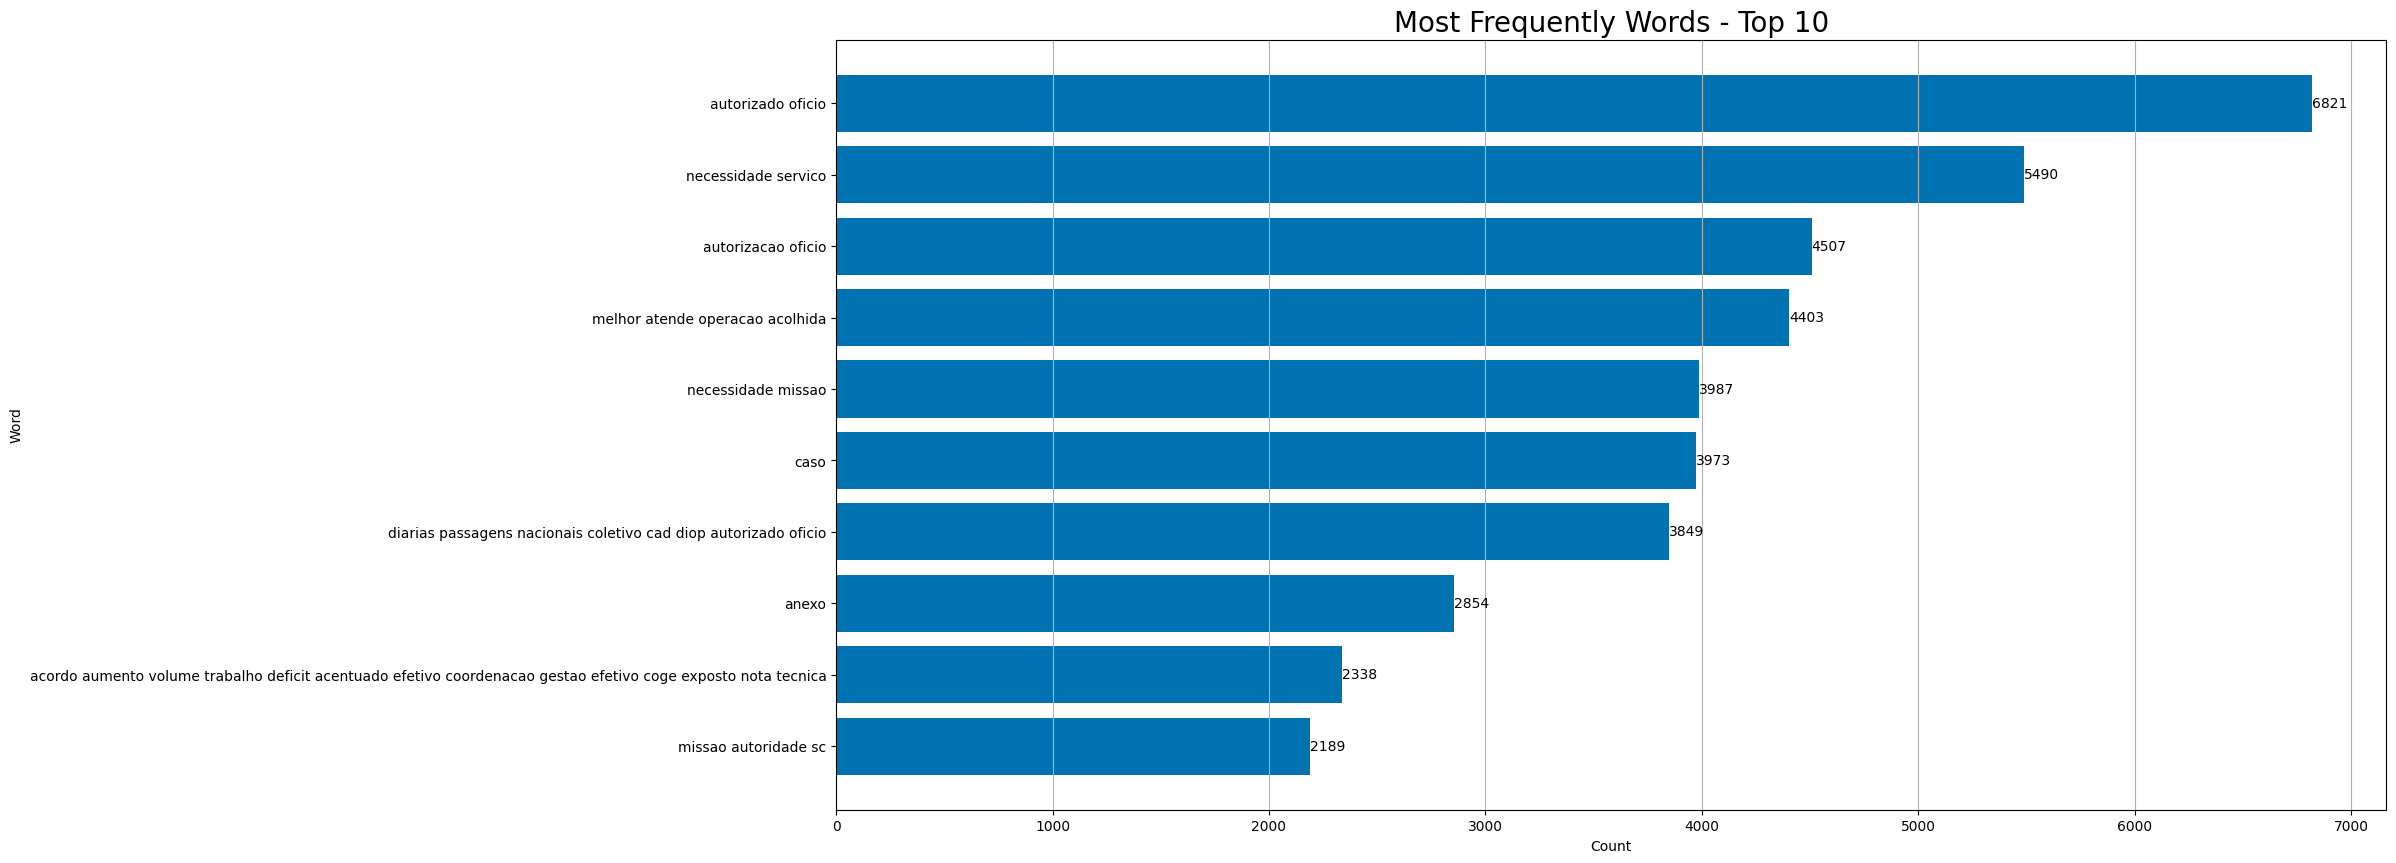

In [17]:
plot_barh(counter_phrases, top=10)

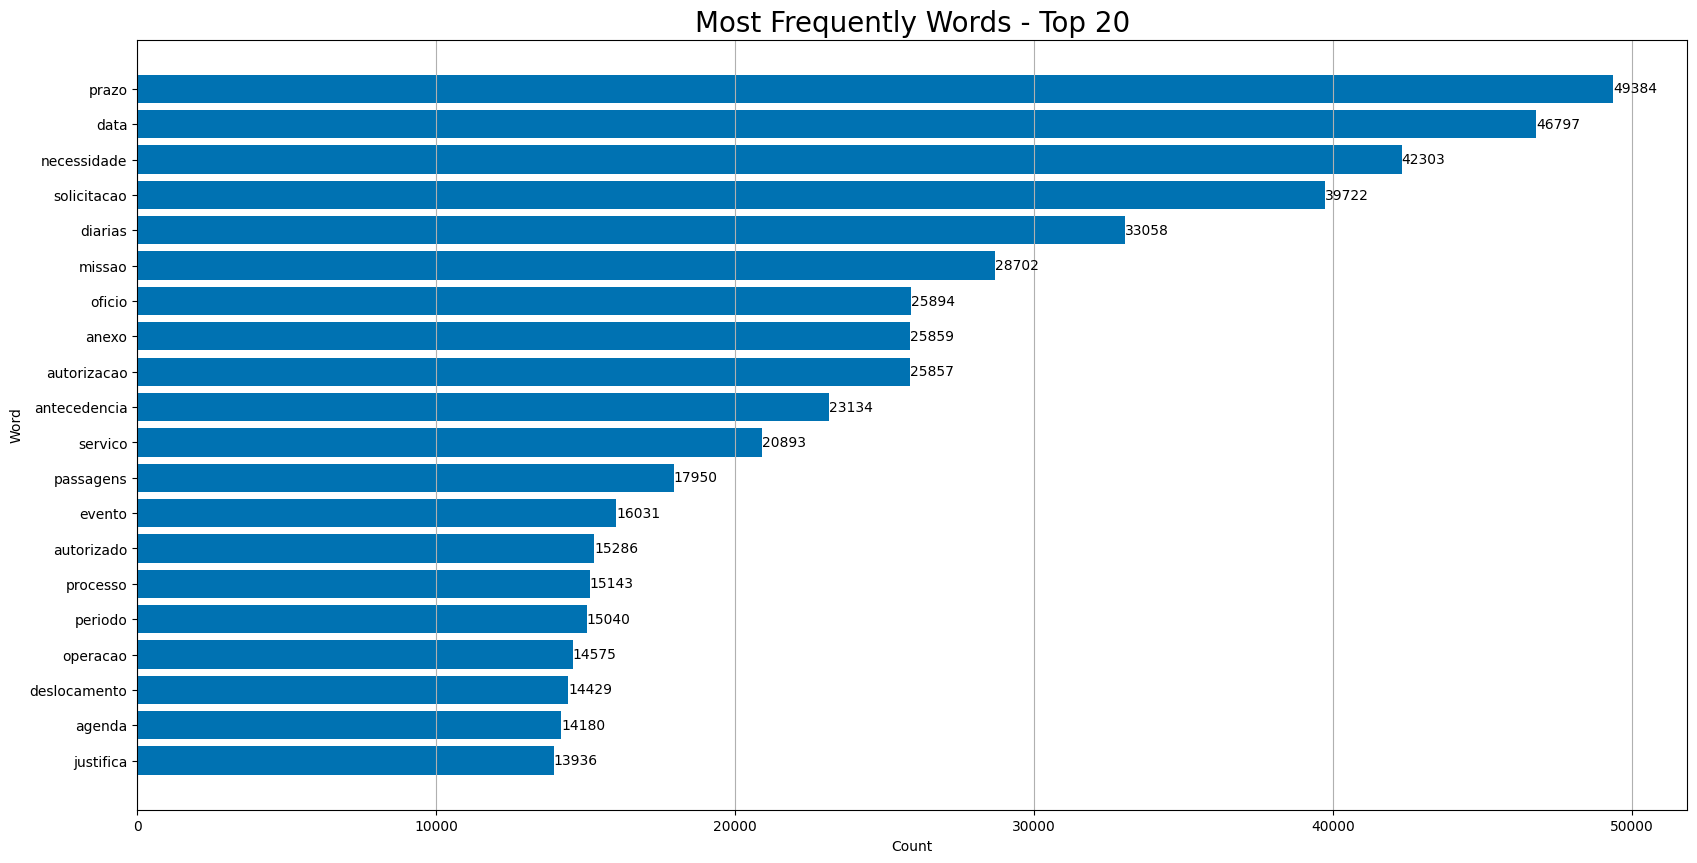

In [18]:
plot_barh(counter_words, top=20)

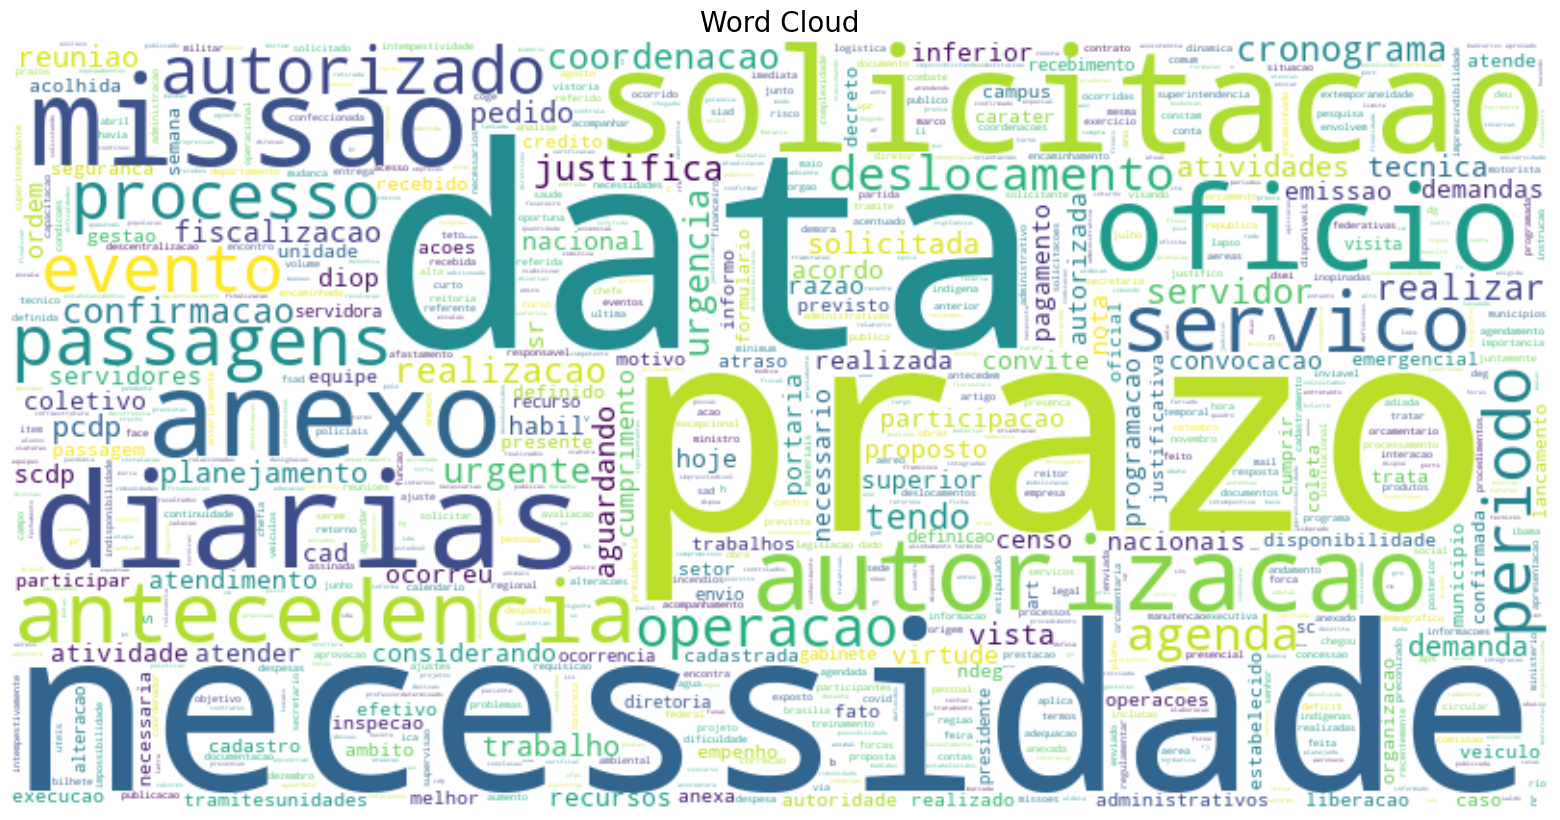

In [19]:
plot_word_cloud(counter_words)

In [20]:
viagem_df.to_csv('2022_Viagem_texto_limpo.csv', sep=";", encoding="latin-1", index=False)